<a href="https://colab.research.google.com/github/Ana-AlonsoCanizares/AA_GRUPO3/blob/main/PruebaControl_OCASO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Medición Prueba de Control
Archivo para medir las diferencias de accesos y lecturas en el grupo experimental frente al de control **(OJO, hay que añadir tb la parte de producción y tendencia).**

Diariamente se descargan los datos de la auditoria de los usuarios desde el lunes sábado 13 de Abril de 2024 a las 00:00 horas hasta el momento actual.

In [1]:
pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.2 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt

Defino el grupo experimental como Gr1 y el de control como Gr2.

Hay que tener en cuenta que agentes_inicio son todos los agentes que había el viernes 12 de Abril, se hará un cruce con los agentes del grupo experimental para crear el Gr1.

##Archivos necesarios
Auditoria (descargar todos los días), 1.18 para ver las bajas (descargar todos los días), estructura comercial, grupo control, estandar grupo experimental, formacion grupo experimental, exp_ctrl que es auditoria meses previos grupo experimental (descargar todos los días para meses (o semanas) previos) y el 1.12.1 producción por meses (descargar de vez en cuando).

Subir todos al colab para ser ejecutados.

In [274]:
accesos_usuarios_df = pd.read_excel('/content/2.13_Auditoria_usuarios.xlsx')
agentes_inicio = pd.read_excel('/content/1.18_Estructura_Comercial.xlsx')
Gr2 = pd.read_excel('/content/1.18_Grupo_de_control.xlsx')
est_gr_exp = pd.read_excel('/content/estandar_gr_exp.xlsx')
for_gr_exp = pd.read_excel('/content/formacion_gr_exp.xlsx')
bajas = pd.read_excel('/content/1.18_Bajas.xlsx')
prod_fis_corr = pd.read_excel('/content/1.12.1_Produccion_Meses.xlsx')

# Prueba grupo experimental como grupo de control_2
aud_gr1_2 = pd.read_excel('/content/Exp_Ctrl.xlsx')

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



Definición de funciones de limpieza y normalización de los dataframes.

In [206]:
def cols_to_keep(df):
  cols = ['SUCURSAL', 'OFICINA', 'PV', 'CODIGO', 'COD. CALLIDUS/SOLNET', 'LDAP', 'NIF', 'NOMBRE', 'TIPOLOGIA', 'F.ALTA']
  df = df[cols]
  return df

def clean_df(df):
    # Convertir todas las columnas de tipo object a mayúsculas, excepto las especificadas
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(lambda x: unidecode(x.upper()) if isinstance(x, str) else x)

    # Ahora, aplicamos unidecode a los nombres de las columnas
    df.columns = [unidecode(col.upper()) for col in df.columns]
    return df

def date_delete(df):
    df['DIA'] = df['FECHA ESPANOLA'].dt.day
    df['MES'] = df['FECHA ESPANOLA'].dt.month

    # Elimino la columna fecha del servidor, ya que nos vamos a quedar solo con la fecha española
    del_columns = ['FECHA SERVIDOR']
    df.drop(columns=del_columns, inplace=True)
    # Elimino la columna unnamed si la hay
    if 'UNNAMED: 0' in df.columns:
      df.drop(columns='UNNAMED: 0', inplace=True)
    return df

def clean_production(df):
    columns = ['POSITIONNAME', 'FEC. ALTA', 'POL. FIS. 2024-01', 'POL. FIS. 2024-02', 'POL. FIS. 2024-03', 'POL. FIS. 2024-04', 'POL. CORR. 2024-01', 'POL. CORR. 2024-02', 'POL. CORR. 2024-03', 'POL. CORR. 2024-04']
    df = df[columns]
    df['PRIMER TRIM POL FIS'] = df['POL. FIS. 2024-01'] + df['POL. FIS. 2024-02'] + df['POL. FIS. 2024-03']
    df['SEGUNDO TRIM POL FIS'] = df['POL. FIS. 2024-04']
    # SUMAR EL RESTO DE MESES CUANDO ESTÉN + df['POL. FIS. 2024-02'] + df['POL. FIS. 2024-03']

    df['POL. CORR. 2024-01'] = pd.to_numeric(df['POL. CORR. 2024-01'].astype(str).str.replace(',', '.'), errors='coerce')
    df['POL. CORR. 2024-02'] = pd.to_numeric(df['POL. CORR. 2024-02'].astype(str).str.replace(',', '.'), errors='coerce')
    df['POL. CORR. 2024-03'] = pd.to_numeric(df['POL. CORR. 2024-03'].astype(str).str.replace(',', '.'), errors='coerce')
    df['POL. CORR. 2024-04'] = pd.to_numeric(df['POL. CORR. 2024-04'].astype(str).str.replace(',', '.'), errors='coerce')
    # df['POL. CORR. 2024-05'] = pd.to_numeric(df['POL. CORR. 2024-05'].astype(str).str.replace(',', '.'), errors='coerce')
    # df['POL. CORR. 2024-06'] = pd.to_numeric(df['POL. CORR. 2024-06'].astype(str).str.replace(',', '.'), errors='coerce')

    df['PRIMER TRIM POL CORR'] = df['POL. CORR. 2024-01'] + df['POL. CORR. 2024-02'] + df['POL. CORR. 2024-03']
    df['SEGUNDO TRIM POL CORR'] = df['POL. CORR. 2024-04']
    # SUMAR EL RESTO DE MESES CUANDO ESTÉN + df['POL. CORR. 2024-02'] + df['POL. CORR. 2024-03']
    return df

In [275]:
# Limpieza y normalización de los dataframes
accesos_usuarios_df = clean_df(accesos_usuarios_df)
accesos_usuarios_df = date_delete(accesos_usuarios_df)

aud_gr1_2 = clean_df(aud_gr1_2)
aud_gr1_2 = date_delete(aud_gr1_2)

agentes_inicio = cols_to_keep(agentes_inicio)
agentes_inicio = clean_df(agentes_inicio)

Gr2 = cols_to_keep(Gr2)
Gr2 = clean_df(Gr2)

for_gr_exp = clean_df(for_gr_exp)
est_gr_exp = clean_df(est_gr_exp)

bajas = clean_df(bajas)

prod_fis_corr = clean_df(prod_fis_corr)
prod_fis_corr = clean_production(prod_fis_corr)

<ipython-input-206-be46b8cab78f>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-206-be46b8cab78f>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-206-be46b8cab78f>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-206-

In [340]:
# Elimino a IRENE DELGADO JIMENEZ el outlier del Grupo de ctrl
Gr2 = Gr2[Gr2['NOMBRE'] != 'IRENE DELGADO JIMENEZ']

In [341]:
gr_exp = pd.concat([for_gr_exp, est_gr_exp], ignore_index=True)

In [342]:
Gr1_2 = agentes_inicio[agentes_inicio['COD. CALLIDUS/SOLNET'].isin(gr_exp['NAME'])]

In [343]:
Gr1 = agentes_inicio[agentes_inicio['COD. CALLIDUS/SOLNET'].isin(gr_exp['NAME'])]

La columna 'LDAP' es el código que identifica al agente en los archivos Gr1 y Gr2, y 'USERID' en accesos_usuarios_df, los que hay que tener en cuenta al cruzar los dataframes.

Los mezclo para quedarme con todas las columnas y poder hablar de sucursales y otros conceptos.

In [344]:
accesos_gr_exp = pd.merge(accesos_usuarios_df, Gr1, how = 'inner', left_on = 'USERID', right_on = 'LDAP')
accesos_gr_ctrl = pd.merge(accesos_usuarios_df, Gr2, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

accesos_gr_ctrl1_2 = pd.merge(aud_gr1_2, Gr1_2, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

prueba = pd.merge(aud_gr1_2, Gr2, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

##Distintas formas de medición


###Diferencia por Tipos de evento

Vemas cuáles son las diferencias entre los diferentes tipos de evento (LOGIN, LOGOUT, VIEW y READ) entre el grupo de control y el experimental.

#####Experimental VS Control

In [345]:
dif_eventos_exp = accesos_gr_exp.groupby(by=['TIPO EVENTO'], as_index=False).count()
dif_eventos_ctrl = accesos_gr_ctrl.groupby(by=['TIPO EVENTO'], as_index=False).count()

dif_eventos_ctrl1_2 = accesos_gr_ctrl1_2.groupby(by=['TIPO EVENTO'], as_index=False).count()

**OJO: ¿cómo puedo cambiar la leyenda?**

<ipython-input-346-b3974ed92c57>:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



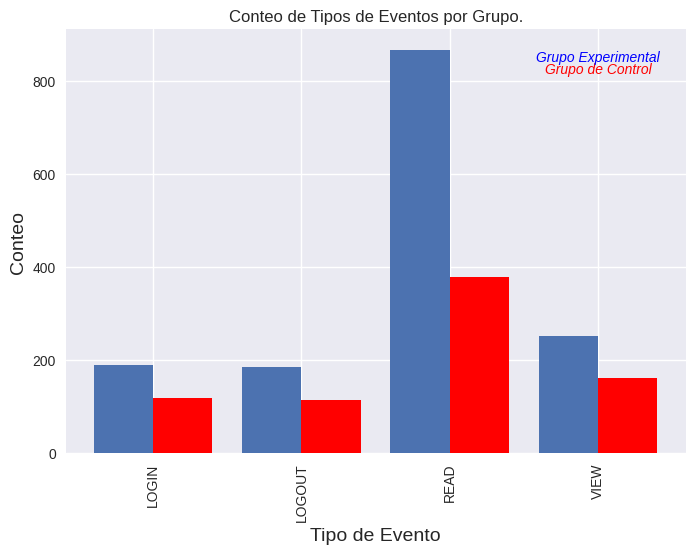

In [346]:
plt.style.use('seaborn')
ax = dif_eventos_exp['USERID'].plot(kind="bar", width=-0.4, rot=0, stacked=True, align='edge')
dif_eventos_ctrl['USERID'].plot(ax=ax, width=0.4, kind="bar",align='edge', color="red")
ax.set_xticklabels(dif_eventos_exp['TIPO EVENTO'])
ax.set_ylabel('Conteo', fontsize = 14)
ax.set_xlabel('Tipo de Evento', fontsize = 14)
# ax.legend(title='DataFrame')
ax.set_title('Conteo de Tipos de Eventos por Grupo.')
ax.text(3, 825, "Grupo de Control",
       fontsize = 10,          # Tamaño
       fontstyle = "oblique",  # Estilo
       color = "red",          # Color
       ha = "center", # Alineación horizontal
       va = "center") # Alineación vertical
ax.text(3, 850, "Grupo Experimental",
       fontsize = 10,          # Tamaño
       fontstyle = "oblique",  # Estilo
       color = "blue",          # Color
       ha = "center", # Alineación horizontal
       va = "center") # Alineación vertical
plt.autoscale(enable=True, axis='x')
plt.show()

In [347]:
for i in range(len(dif_eventos_exp)):
  porcentaje = round((dif_eventos_ctrl['USERID'].iloc[i-1]*100)/dif_eventos_exp['USERID'].iloc[i-1],2)
  print('El evento', dif_eventos_exp['TIPO EVENTO'].iloc[i-1], 'del grupo de control supone un ', porcentaje, '% siendo el 100 % lo recogido en el grupo experimental.')
  print('Que se corresponde con', dif_eventos_ctrl['USERID'].iloc[i-1],'registros obtenidos del grupo de control y', dif_eventos_exp['USERID'].iloc[i-1], 'del grupo experimental.\n')

El evento VIEW del grupo de control supone un  64.29 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 162 registros obtenidos del grupo de control y 252 del grupo experimental.

El evento LOGIN del grupo de control supone un  62.11 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 118 registros obtenidos del grupo de control y 190 del grupo experimental.

El evento LOGOUT del grupo de control supone un  61.96 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 114 registros obtenidos del grupo de control y 184 del grupo experimental.

El evento READ del grupo de control supone un  43.6 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 378 registros obtenidos del grupo de control y 867 del grupo experimental.



#####Grupo Experimental (1º Trim VS 2º Trim)

<ipython-input-348-e9a12d207394>:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



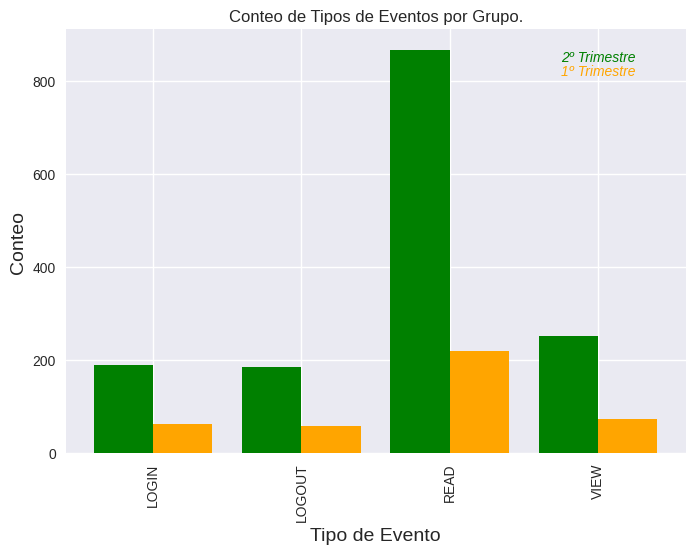

In [348]:
plt.style.use('seaborn')
ax = dif_eventos_exp['USERID'].plot(kind="bar", width=-0.4, rot=0, stacked=True, align='edge', color="green")
dif_eventos_ctrl1_2['USERID'].plot(ax=ax, width=0.4, kind="bar",align='edge', color="orange")
ax.set_xticklabels(dif_eventos_exp['TIPO EVENTO'])
ax.set_ylabel('Conteo', fontsize = 14)
ax.set_xlabel('Tipo de Evento', fontsize = 14)
# ax.legend(title='DataFrame')
ax.set_title('Conteo de Tipos de Eventos por Grupo.')
ax.text(3, 820, "1º Trimestre",
       fontsize = 10,          # Tamaño
       fontstyle = "oblique",  # Estilo
       color = "orange",          # Color
       ha = "center", # Alineación horizontal
       va = "center") # Alineación vertical
ax.text(3, 850, "2º Trimestre",
       fontsize = 10,          # Tamaño
       fontstyle = "oblique",  # Estilo
       color = "green",          # Color
       ha = "center", # Alineación horizontal
       va = "center") # Alineación vertical
plt.autoscale(enable=True, axis='x')
plt.show()

Vamos a contemplar que el grupo experimental es el 100% (la totalidad) para ver las diferencias porcentuales con el grupo de control.

Y sacamos en otra frase a qué número exacto corresponden estos porcentajes.

In [349]:
# Grupo exp como ctrl_2
for i in range(len(dif_eventos_exp)):
  porcentaje = round((dif_eventos_ctrl1_2['USERID'].iloc[i-1]*100)/dif_eventos_exp['USERID'].iloc[i-1],2)
  print('El evento', dif_eventos_exp['TIPO EVENTO'].iloc[i-1], 'del grupo experimental como grupo de control supone un ', porcentaje, '% siendo el 100 % lo recogido en el grupo experimental.')
  print('Que se corresponde con', dif_eventos_ctrl1_2['USERID'].iloc[i-1],'registros obtenidos del grupo como control y', dif_eventos_exp['USERID'].iloc[i-1], 'del grupo como experimental.\n')

El evento VIEW del grupo experimental como grupo de control supone un  29.37 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 74 registros obtenidos del grupo como control y 252 del grupo como experimental.

El evento LOGIN del grupo experimental como grupo de control supone un  32.63 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 62 registros obtenidos del grupo como control y 190 del grupo como experimental.

El evento LOGOUT del grupo experimental como grupo de control supone un  32.07 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 59 registros obtenidos del grupo como control y 184 del grupo como experimental.

El evento READ del grupo experimental como grupo de control supone un  25.37 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 220 registros obtenidos del grupo como control y 867 del grupo como experimental.



###Diferencias Tipo Evento - Sucursal
Medimos cuál es el impacto, número de veces que se producen, de cada tipo de evento en cada sucursal (por un lado del grupo experimental y por otro del grupo de control).

In [350]:
import plotly.express as px

dif_sucursales_exp = accesos_gr_exp.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(dif_sucursales_exp, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

OJOOOOO, CAMBIAR LO DE VIEW, HAY QUE SACAR BIEN EL TIPO DE EVENTO Y LA SUCURSAL, EN FUNCIÓN DEL MÁXIMO CONSEGUIDO.

In [351]:
print('El evento con más registros es', max(dif_sucursales_exp['TIPO EVENTO']),'en la sucursal', max(dif_sucursales_exp['SUCURSAL']), 'con un total de', max(dif_sucursales_exp['USERID']))

El evento con más registros es VIEW en la sucursal 0512 - VENTAS con un total de 191


In [352]:
dif_suc_prueba = prueba.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(dif_suc_prueba, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

In [353]:
dif_sucursales_ctrl = accesos_gr_ctrl.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(dif_sucursales_ctrl, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

IGUAL QUE ARRIBA, ESTÁ MAAAAAAAAAAAL

In [354]:
print('El evento con más registros es', max(dif_sucursales_ctrl['TIPO EVENTO']),'en la sucursal', max(dif_sucursales_ctrl['SUCURSAL']), 'con un total de', max(dif_sucursales_ctrl['USERID']))

El evento con más registros es VIEW en la sucursal 0718 - VALDEMORO con un total de 83


In [355]:
# Grupo exp como ctrl
dif_sucursales_ctrl1_2 = accesos_gr_ctrl1_2.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(dif_sucursales_ctrl1_2, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

####Cambio sucursales por puntos de venta
Sacamos el mismo estudio para los puntos de venta (PV) en vez de las sucursales.

In [356]:
dif_PV_exp = accesos_gr_exp.groupby(by=['TIPO EVENTO', 'PV'], as_index=False).count()

fig = px.scatter(dif_PV_exp, y="TIPO EVENTO", x="PV", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

###Diferencia de accesos por tipología de agente
Medimos cuál es el impacto que tiene cada tipo de agente en los eventos, ¿están accediendo más los agentes en formación (16) o los estándar (37)?

In [357]:
dif_tipologia_prueba = prueba.groupby(by=['TIPO EVENTO', 'TIPOLOGIA'], as_index=False).count()

fig = px.scatter(dif_tipologia_prueba, y="TIPO EVENTO", x="TIPOLOGIA", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

In [358]:
dif_tipologia_exp = accesos_gr_exp.groupby(by=['TIPO EVENTO', 'TIPOLOGIA'], as_index=False).count()

fig = px.scatter(dif_tipologia_exp, y="TIPO EVENTO", x="TIPOLOGIA", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

In [359]:
dif_tipologia_ctrl = accesos_gr_ctrl.groupby(by=['TIPO EVENTO', 'TIPOLOGIA'], as_index=False).count()
fig = px.scatter(dif_tipologia_ctrl, y="TIPO EVENTO", x="TIPOLOGIA", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

In [360]:
# Grupo exp como ctrl
dif_tipologia_ctrl1_2 = accesos_gr_ctrl1_2.groupby(by=['TIPO EVENTO', 'TIPOLOGIA'], as_index=False).count()
fig = px.scatter(dif_tipologia_ctrl1_2, y="TIPO EVENTO", x="TIPOLOGIA", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

###Agentes en Formación usando los informes
En esta parte del código, vemos qué agentes (del grupo experimental) en formación están usando los informes por sucursal. Código para estar al tanto de cómo ha sido la formación en cascada.

In [361]:
df_for = Gr1[Gr1["TIPOLOGIA"].str.contains("FORMACION")]

accesos_for_exp = pd.merge(accesos_usuarios_df, df_for, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_for_exp = accesos_for_exp.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_for_exp, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

Vemos en cuántas (y cuáles son) sucursales hay agentes en formación dentro del grupo experimental para saber si están entrando agentes de todas ellas. Observamos que hay 11, luego ya han accedido desde todas.

In [362]:
df_for['SUCURSAL'].unique()

array(['0004 - ALCALA DE HENARES', '0212 - MADRID-G.B.', '0215 - VAGUADA',
       '0222 - VILLALBA', '0233 - ALCOBENDAS', '0234 - COSLADA',
       '0242 - LAS ROSAS', '0278 - MADRID-HORTALEZA',
       '0332 - TORREJON DE ARDOZ', '0462 - LAS ROZAS', '0512 - VENTAS'],
      dtype=object)

####Para el grupo de control
Uso de informes para los agentes en formación del grupo de control. ¿Cuánto usan Callidus los agentes en formación sin informes nuevos relevantes?

In [363]:
df2_for = Gr2[Gr2["TIPOLOGIA"].str.contains("FORMACION")]

accesos_for_ctrl = pd.merge(accesos_usuarios_df, df2_for, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_for_ctrl = accesos_for_ctrl.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_for_ctrl, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

Vemos en cuántas (y cuáles son) sucursales hay agentes en formación dentro del grupo de control para saber si están entrando agentes de todas ellas. Observamos que hay 12 y solo se ha accedido desde 8 **(cambiar diariamente si esto cambia)**.

In [364]:
df2_for['SUCURSAL'].unique()

array(['0018 - ARANJUEZ', '0214 - MOSTOLES', '0218 - FUENLABRADA',
       '0220 - LEGANES', '0221 - ALCORCON', '0223 - PARLA',
       '0255 - GETAFE', '0277 - MADRID-BUENAVISTA', '0312 - VALLECAS',
       '0412 - CARABANCHEL', '0442 - MADRID-CIUDAD DE LOS ANGELES',
       '0718 - VALDEMORO'], dtype=object)

In [365]:
# Grupo exp como ctrl
df1_2_for = Gr1_2[Gr1_2["TIPOLOGIA"].str.contains("FORMACION")]

accesos_for_ctrl1_2 = pd.merge(aud_gr1_2, df1_2_for, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_for_ctrl1_2 = accesos_for_ctrl1_2.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_for_ctrl1_2, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

5 sucursales de 11 **(CAMBIAR SI SE COGEN MÁS MESE ATRÁS Y VARÍA)**.

In [366]:
df1_2_for['SUCURSAL'].unique()

array(['0004 - ALCALA DE HENARES', '0212 - MADRID-G.B.', '0215 - VAGUADA',
       '0222 - VILLALBA', '0233 - ALCOBENDAS', '0234 - COSLADA',
       '0242 - LAS ROSAS', '0278 - MADRID-HORTALEZA',
       '0332 - TORREJON DE ARDOZ', '0462 - LAS ROZAS', '0512 - VENTAS'],
      dtype=object)

###Agentes Estándar usando los informes
En esta parte del código, vemos qué agentes (del grupo experimental) de tipo estándar, están usando los informes por sucursal. Código para comparar con los de formación y ver si es mejor contar de primera mano la información o la formación en cascada y, medir qué tipología de agente encuentra más relevante los informes.

In [367]:
df_est_prueba = Gr2[Gr2["TIPOLOGIA"].str.contains("ESTANDAR")]

accesos_est_prueba = pd.merge(aud_gr1_2, df_est_prueba, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_est_prueba = accesos_est_prueba.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_est_prueba, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

In [368]:
df_est = Gr1[Gr1["TIPOLOGIA"].str.contains("ESTANDAR")]

accesos_est_exp = pd.merge(accesos_usuarios_df, df_est, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_est_exp = accesos_est_exp.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_est_exp, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

Vemos en cuántas (y cuáles son) sucursales hay agentes estándar dentro del grupo experimental para saber si están entrando agentes de todas ellas. Observamos que hay 10, ya han entrado todos.

In [369]:
df_est['SUCURSAL'].unique()

array(['0004 - ALCALA DE HENARES', '0212 - MADRID-G.B.', '0215 - VAGUADA',
       '0222 - VILLALBA', '0233 - ALCOBENDAS', '0234 - COSLADA',
       '0242 - LAS ROSAS', '0278 - MADRID-HORTALEZA',
       '0332 - TORREJON DE ARDOZ', '0462 - LAS ROZAS'], dtype=object)

Voy a sacar el número de agentes que hay en esta sucursal, para saber si es importante esta falta de accesos o no. Hay dos agentes en esta sucursal, no supone mucho impacto.

In [370]:
vaguada_est = df_est[df_est['SUCURSAL'].str.contains('VAGUADA')]

vaguada_est

,SUCURSAL,OFICINA,PV,CODIGO,COD. CALLIDUS/SOLNET,LDAP,NIF,NOMBRE,TIPOLOGIA,F.ALTA
1648,0215 - VAGUADA,0215 - VAGUADA,215,9270,Z0157154T0000,Z0157154T0000,Z0157154T,CLAUDIA LIZETH VALENZUELA MALDONADO,37 - AGENTE ESTANDAR,2023-02-10
1650,0215 - VAGUADA,0215 - VAGUADA,215,9274,Y7170466T0000,Y7170466T0000,Y7170466T,ADRIANA OLMOS ARAGORT,37 - AGENTE ESTANDAR,2023-04-18


####Para el grupo de control
Uso de informes para los agentes estándar del grupo de control. ¿Cuánto usan Callidus estos agentes sin informes nuevos relevantes? ¿Usan Callidus como herramienta de ayuda?

In [371]:
df2_est = Gr2[Gr2["TIPOLOGIA"].str.contains("ESTANDAR")]

accesos_est_ctrl = pd.merge(accesos_usuarios_df, df2_est, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_est_ctrl = accesos_est_ctrl.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_est_ctrl, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

Vemos en cuántas (y cuáles son) sucursales hay agentes estándar dentro del grupo de control para saber si están entrando agentes de todas ellas. Observamos que hay 11 y solo se ha accedido desde 8 sucursales **(cambiar si se modifica)**.

In [372]:
df2_est['SUCURSAL'].unique()

array(['0214 - MOSTOLES', '0218 - FUENLABRADA', '0220 - LEGANES',
       '0221 - ALCORCON', '0223 - PARLA', '0255 - GETAFE',
       '0277 - MADRID-BUENAVISTA', '0312 - VALLECAS',
       '0412 - CARABANCHEL', '0442 - MADRID-CIUDAD DE LOS ANGELES',
       '0718 - VALDEMORO'], dtype=object)

In [373]:
# Grupo exp como ctrl
df1_2_est = Gr1_2[Gr1_2["TIPOLOGIA"].str.contains("ESTANDAR")]

accesos_est_ctrl1_2 = pd.merge(aud_gr1_2, df1_2_est, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_est_ctrl1_2 = accesos_est_ctrl1_2.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_est_ctrl1_2, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

###Impacto por agente
¿Cuántos agentes del grupo experimental están haciendo uso de los informes? ¿Cuáles de ellos acceden a Callidus? ¿Es un número alto?

Primero para los agentes en formación del grupo experimental.

In [374]:
agentes_est_prueba = prueba.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_est_prueba, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.show()

In [375]:
agentes_for_exp = accesos_for_exp.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_for_exp, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.show()

In [376]:
# CODIGO PARA ENCONTRAR AGENTES CONCRETOS
# agente = Gr1[Gr1["NOMBRE"].str.contains("BEAT")]
# agente

In [377]:
agentes_est_exp = accesos_est_exp.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_est_exp, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.show()

Cuántos agentes están usando los informes, por tipología y en su totalidad.

Totalidad de agentes en el grupo experimental y según la tipología.

In [378]:
print('Hay', agentes_for_exp['NOMBRE USUARIO'].nunique(), 'agentes en formación del grupo experimental usando los informes y', agentes_est_exp['NOMBRE USUARIO'].nunique(), 'agentes estándar, es decir, un total de', agentes_for_exp['NOMBRE USUARIO'].nunique() + agentes_est_exp['NOMBRE USUARIO'].nunique(), 'agentes.')
print('Hay', df_for['NOMBRE'].nunique(), 'agentes en formación y', df_est['NOMBRE'].nunique(), 'agentes estándar en el grupo experimental, es decir, un total de', df_for['NOMBRE'].nunique() + df_est['NOMBRE'].nunique(), 'agentes.')

Hay 21 agentes en formación del grupo experimental usando los informes y 19 agentes estándar, es decir, un total de 40 agentes.
Hay 51 agentes en formación y 28 agentes estándar en el grupo experimental, es decir, un total de 79 agentes.


Medimos porcentualmente qué representan estos datos.

In [379]:
dif_for_exp = round((100*agentes_for_exp['NOMBRE USUARIO'].nunique())/df_for['NOMBRE'].nunique(),2)

dif_est_exp = round((100*agentes_est_exp['NOMBRE USUARIO'].nunique())/df_est['NOMBRE'].nunique(),2)

total_usando = agentes_for_exp['NOMBRE USUARIO'].nunique() + agentes_est_exp['NOMBRE USUARIO'].nunique()
total_exp = (df_for['NOMBRE'].nunique() + df_est['NOMBRE'].nunique())

dif_total_exp = round((100*total_usando)/total_exp,2)

print('Hay', dif_for_exp, '% de agentes en formación y', dif_est_exp, '% agentes estándar usando los informes, es decir, un total de', dif_total_exp, '% de agentes.')

Hay 41.18 % de agentes en formación y 67.86 % agentes estándar usando los informes, es decir, un total de 50.63 % de agentes.


####Para el grupo de control

In [380]:
agentes_for_ctrl = accesos_for_ctrl.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_for_ctrl, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.show()

In [381]:
agentes_est_ctrl = accesos_est_ctrl.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_est_ctrl, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.show()

In [382]:
agente = Gr2[Gr2["NOMBRE"].str.contains("IRENE")]
agente

,SUCURSAL,OFICINA,PV,CODIGO,COD. CALLIDUS/SOLNET,LDAP,NIF,NOMBRE,TIPOLOGIA,F.ALTA


In [383]:
print('Hay', agentes_for_ctrl['NOMBRE USUARIO'].nunique(), 'agentes en formación usando Callidus del grupo de control y', agentes_est_ctrl['NOMBRE USUARIO'].nunique(), 'agentes estándar, es decir, un total de', agentes_for_ctrl['NOMBRE USUARIO'].nunique() + agentes_est_ctrl['NOMBRE USUARIO'].nunique(), 'agentes.')
print('Hay', df2_for['NOMBRE'].nunique(), 'agentes en formación y', df2_est['NOMBRE'].nunique(), 'agentes estándar en el grupo de control, es decir, un total de', df2_for['NOMBRE'].nunique() + df2_est['NOMBRE'].nunique(), 'agentes.')

Hay 19 agentes en formación usando Callidus del grupo de control y 13 agentes estándar, es decir, un total de 32 agentes.
Hay 65 agentes en formación y 19 agentes estándar en el grupo de control, es decir, un total de 84 agentes.


Medimos los porcentajes.

In [384]:
dif_for_ctrl = round((100*agentes_for_ctrl['NOMBRE USUARIO'].nunique())/df2_for['NOMBRE'].nunique(),2)

dif_est_ctrl = round((100*agentes_est_exp['NOMBRE USUARIO'].nunique())/df2_est['NOMBRE'].nunique(),2)

total_usando_ctrl = agentes_for_ctrl['NOMBRE USUARIO'].nunique() + agentes_est_ctrl['NOMBRE USUARIO'].nunique()
total_ctrl = (df2_for['NOMBRE'].nunique() + df2_est['NOMBRE'].nunique())

dif_total_ctrl = round((100*total_usando_ctrl)/total_ctrl,2)

print('Hay', dif_for_ctrl, '% de agentes en formación y', dif_est_ctrl, '% agentes estándar usando Callidus del grupo de control, es decir, un total de', dif_total_ctrl, '% de agentes.')

Hay 29.23 % de agentes en formación y 100.0 % agentes estándar usando Callidus del grupo de control, es decir, un total de 38.1 % de agentes.


In [385]:
# Grupo exp como ctrl
agentes_for_ctrl1_2 = accesos_for_ctrl1_2.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_for_ctrl1_2, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.show()

In [386]:
# Grupo exp como ctrl
agentes_est_ctrl1_2 = accesos_est_ctrl1_2.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_est_ctrl1_2, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.show()

In [387]:
print('Hay', agentes_for_ctrl1_2['NOMBRE USUARIO'].nunique(), 'agentes en formación usando Callidus del grupo experimental como grupo de control y', agentes_est_ctrl1_2['NOMBRE USUARIO'].nunique(), 'agentes estándar, es decir, un total de', agentes_for_ctrl1_2['NOMBRE USUARIO'].nunique() + agentes_est_ctrl1_2['NOMBRE USUARIO'].nunique(), 'agentes.')
print('Hay', df1_2_for['NOMBRE'].nunique(), 'agentes en formación y', df1_2_est['NOMBRE'].nunique(), 'agentes estándar en el grupo experimental como grupo de control, es decir, un total de', df1_2_for['NOMBRE'].nunique() + df1_2_est['NOMBRE'].nunique(), 'agentes.')

Hay 11 agentes en formación usando Callidus del grupo experimental como grupo de control y 18 agentes estándar, es decir, un total de 29 agentes.
Hay 51 agentes en formación y 28 agentes estándar en el grupo experimental como grupo de control, es decir, un total de 79 agentes.


In [388]:
dif_for_ctrl1_2 = round((100*agentes_for_ctrl1_2['NOMBRE USUARIO'].nunique())/df1_2_for['NOMBRE'].nunique(),2)

dif_est_ctrl1_2 = round((100*agentes_est_ctrl1_2['NOMBRE USUARIO'].nunique())/df1_2_est['NOMBRE'].nunique(),2)

total_usando_ctrl1_2 = agentes_for_ctrl1_2['NOMBRE USUARIO'].nunique() + agentes_est_ctrl1_2['NOMBRE USUARIO'].nunique()
total_ctrl1_2 = (df1_2_for['NOMBRE'].nunique() + df1_2_est['NOMBRE'].nunique())

dif_total_ctrl1_2 = round((100*total_usando_ctrl1_2)/total_ctrl1_2,2)

print('Hay', dif_for_ctrl1_2, '% de agentes en formación y', dif_est_ctrl1_2, '% agentes estándar usando Callidus del grupo experimental como control, es decir, un total de', dif_total_ctrl1_2, '% de agentes.')

Hay 21.57 % de agentes en formación y 64.29 % agentes estándar usando Callidus del grupo experimental como control, es decir, un total de 36.71 % de agentes.


###Medimos las Bajas
Vamos a ver los agentes de ambos grupos que se han dado de baja hasta el momento, a partir del 1.18 la parte de agentes inactivos que será subida diariamente.

####Bajas de los agentes del grupo experimental

In [389]:
bajas_exp = Gr1[Gr1['NOMBRE'].isin(bajas['NOMBRE'].unique())]

bajas_exp

,SUCURSAL,OFICINA,PV,CODIGO,COD. CALLIDUS/SOLNET,LDAP,NIF,NOMBRE,TIPOLOGIA,F.ALTA


####Bajas de los agentes del grupo de control

In [390]:
bajas_ctrl = Gr2[Gr2['NOMBRE'].isin(bajas['NOMBRE'].unique())]

bajas_ctrl

,SUCURSAL,OFICINA,PV,CODIGO,COD. CALLIDUS/SOLNET,LDAP,NIF,NOMBRE,TIPOLOGIA,F.ALTA
18,0220 - LEGANES,0220 - LEGANES,220,9000,14077527D0000,14077527D0000,14077527D,YRIS DEL CARMEN GAMBOA GONZALEZ,16 - AGENTE EN FORMACION,2024-03-18


###Medición de la Producción


####Pólizas Físicas y Corregidas
Comenzamos a medir las pólizas (tanto físicas como corregidas) de los agentes del grupo experimental, el de control y la producción del grupo experimental en los meses del primer trimestre.

#####Grupo Experimental (1º Trim VS 2º Trim)

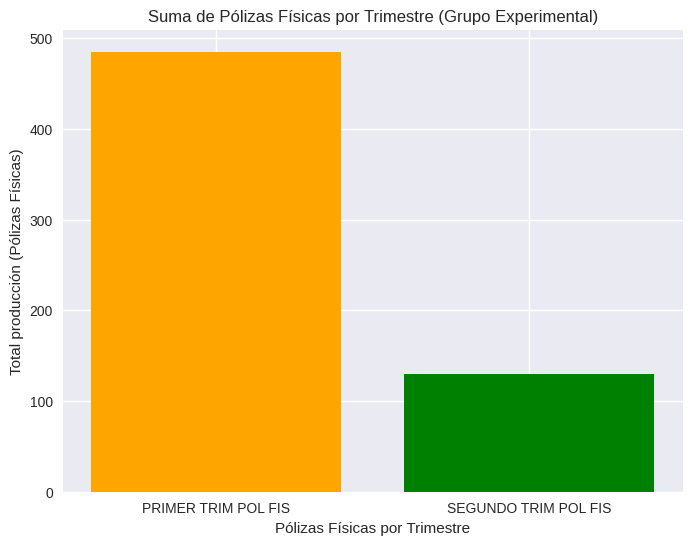

In [391]:
prod_fis_corr_exp = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(Gr1['LDAP'].unique())]

suma_fis_trim1 = prod_fis_corr_exp['PRIMER TRIM POL FIS'].sum()
suma_fis_trim2 = prod_fis_corr_exp['SEGUNDO TRIM POL FIS'].sum()

# Preparar datos para el gráfico
sumas_fis = [suma_fis_trim1, suma_fis_trim2]
columnas_fis = ['PRIMER TRIM POL FIS', 'SEGUNDO TRIM POL FIS']

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_fis, sumas_fis, color=['orange', 'green'])
plt.xlabel('Pólizas Físicas por Trimestre')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Suma de Pólizas Físicas por Trimestre (Grupo Experimental)')
plt.show()

In [392]:
print('En el primer trimestre el grupo experimental hizo', suma_fis_trim1,'pólizas físicas, mientras que en el segundo', suma_fis_trim2,'.')
print('En el primer trimestre el grupo experimental hizo un 100 % pólizas físicas, mientras que en el segundo', round((100*suma_fis_trim2)/suma_fis_trim1,2),'%.')

En el primer trimestre el grupo experimental hizo 485 pólizas físicas, mientras que en el segundo 130 .
En el primer trimestre el grupo experimental hizo un 100 % pólizas físicas, mientras que en el segundo 26.8 %.


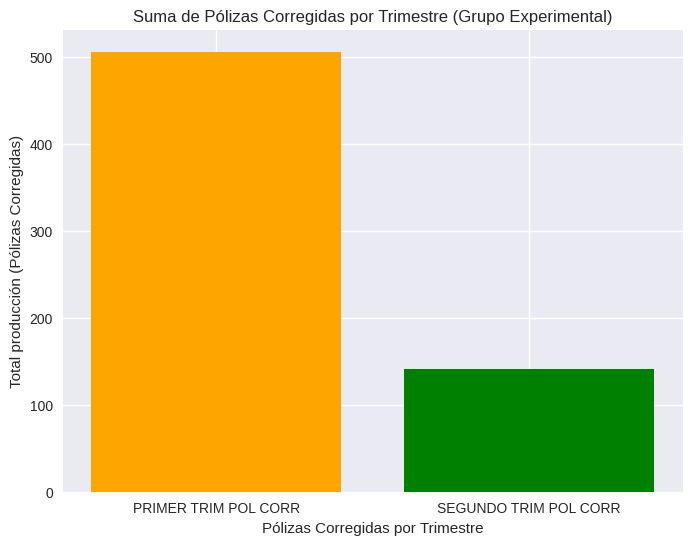

In [393]:
suma_corr_trim1 = prod_fis_corr_exp['PRIMER TRIM POL CORR'].sum()
suma_corr_trim2 = prod_fis_corr_exp['SEGUNDO TRIM POL CORR'].sum()

# Preparar datos para el gráfico
sumas_corr = [suma_corr_trim1, suma_corr_trim2]
columnas_corr = ['PRIMER TRIM POL CORR', 'SEGUNDO TRIM POL CORR']

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_corr, sumas_corr, color=['orange', 'green'])
plt.xlabel('Pólizas Corregidas por Trimestre')
plt.ylabel('Total producción (Pólizas Corregidas)')
plt.title('Suma de Pólizas Corregidas por Trimestre (Grupo Experimental)')
plt.show()

In [394]:
print('En el primer trimestre el grupo experimental hizo', round(suma_corr_trim1),'pólizas corregidas, mientras que en el segundo', round(suma_corr_trim2,2),'.')
print('En el primer trimestre el grupo experimental hizo un 100 % pólizas corregidas, mientras que en el segundo', round((100*suma_corr_trim2)/suma_corr_trim1,2),'%.')

En el primer trimestre el grupo experimental hizo 506 pólizas corregidas, mientras que en el segundo 141.05 .
En el primer trimestre el grupo experimental hizo un 100 % pólizas corregidas, mientras que en el segundo 27.87 %.


#####Grupo de Control (1º Trim VS 2º Trim)

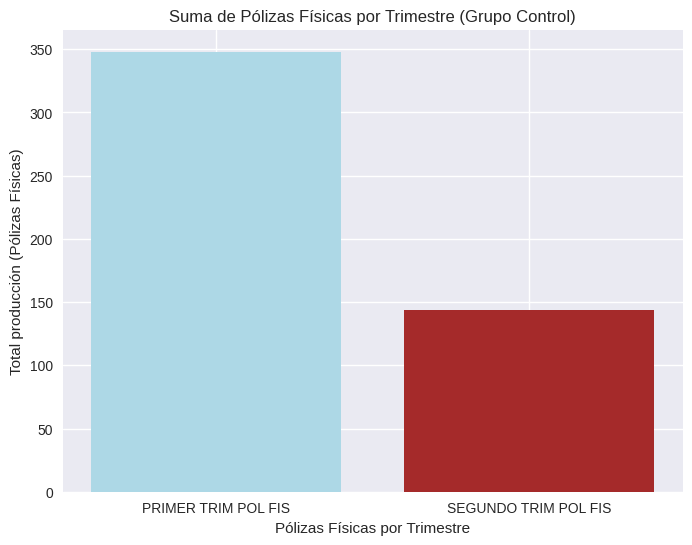

In [395]:
prod_fis_corr_ctrl = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(Gr2['LDAP'].unique())]

suma_fis_trim1_ctrl = prod_fis_corr_ctrl['PRIMER TRIM POL FIS'].sum()
suma_fis_trim2_ctrl = prod_fis_corr_ctrl['SEGUNDO TRIM POL FIS'].sum()

# Preparar datos para el gráfico
sumas_fis_ctrl = [suma_fis_trim1_ctrl, suma_fis_trim2_ctrl]

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_fis, sumas_fis_ctrl, color=['lightblue', 'brown'])
plt.xlabel('Pólizas Físicas por Trimestre')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Suma de Pólizas Físicas por Trimestre (Grupo Control)')
plt.show()

Comparamos los valores y contemplando que las del primer trimestre corresponden al 100% sacamos los porcentajes.

In [396]:
print('En el primer trimestre el grupo de control hizo', suma_fis_trim1_ctrl,'pólizas físicas, mientras que en el segundo', suma_fis_trim2_ctrl,'.')
print('En el primer trimestre el grupo de control hizo un 100 % pólizas físicas, mientras que en el segundo', round((100*suma_fis_trim2_ctrl)/suma_fis_trim1_ctrl,2),'%.')

En el primer trimestre el grupo de control hizo 348 pólizas físicas, mientras que en el segundo 144 .
En el primer trimestre el grupo de control hizo un 100 % pólizas físicas, mientras que en el segundo 41.38 %.


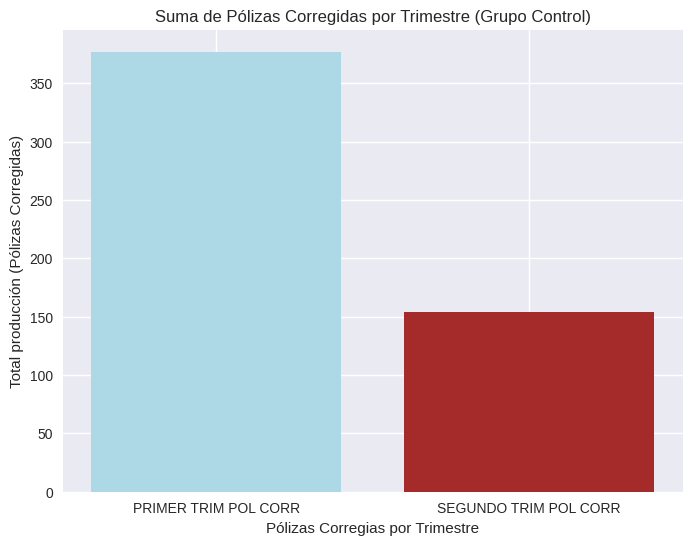

In [397]:
suma_corr_trim1_ctrl = prod_fis_corr_ctrl['PRIMER TRIM POL CORR'].sum()
suma_corr_trim2_ctrl = prod_fis_corr_ctrl['SEGUNDO TRIM POL CORR'].sum()

# Preparar datos para el gráfico
sumas_corr_ctrl = [suma_corr_trim1_ctrl, suma_corr_trim2_ctrl]

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_corr, sumas_corr_ctrl, color=['lightblue', 'brown'])
plt.xlabel('Pólizas Corregias por Trimestre')
plt.ylabel('Total producción (Pólizas Corregidas)')
plt.title('Suma de Pólizas Corregidas por Trimestre (Grupo Control)')
plt.show()

In [398]:
print('En el primer trimestre el grupo de control hizo', round(suma_corr_trim1_ctrl,2),'pólizas corregidas, mientras que en el segundo', round(suma_corr_trim2_ctrl,2),'.')
print('En el primer trimestre el grupo de control hizo un 100 % pólizas corregidas, mientras que en el segundo', round((100*suma_corr_trim2_ctrl)/suma_corr_trim1_ctrl,2),'%.')

En el primer trimestre el grupo de control hizo 377.08 pólizas corregidas, mientras que en el segundo 153.84 .
En el primer trimestre el grupo de control hizo un 100 % pólizas corregidas, mientras que en el segundo 40.8 %.


#####Segundo Trimestre (Experimental VS Control)

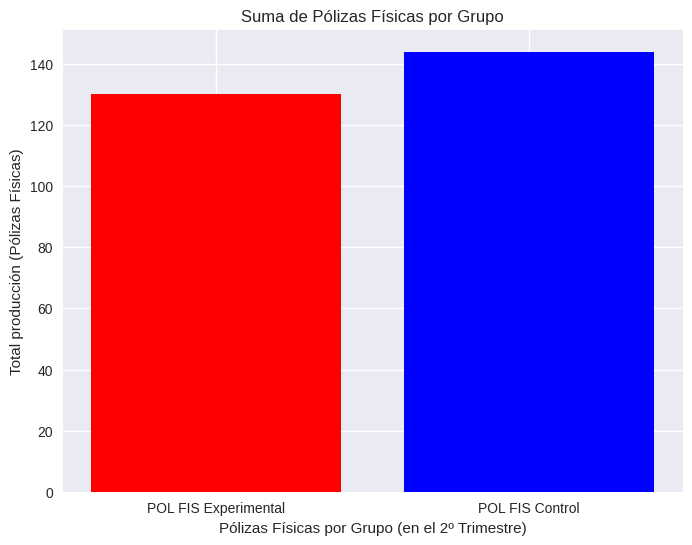

In [399]:
# Preparar datos para el gráfico
sumas_fis_comparativa = [suma_fis_trim2, suma_fis_trim2_ctrl]
columnas_fis_comparativa = ['POL FIS Experimental', 'POL FIS Control']

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_fis_comparativa, sumas_fis_comparativa, color=['red', 'blue'])
plt.xlabel('Pólizas Físicas por Grupo (en el 2º Trimestre)')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Suma de Pólizas Físicas por Grupo')
plt.show()

In [400]:
print('En el segundo trimestre el grupo de control hizo', round(suma_fis_trim2_ctrl,2),'pólizas físicas, mientras que el experimental', round(suma_fis_trim2,2),'.')
print('El grupo de control hizo un 100 % pólizas físicas, mientras que el experimental', round((100*suma_fis_trim2)/suma_fis_trim2_ctrl,2),'%.')

En el segundo trimestre el grupo de control hizo 144 pólizas físicas, mientras que el experimental 130 .
El grupo de control hizo un 100 % pólizas físicas, mientras que el experimental 90.28 %.


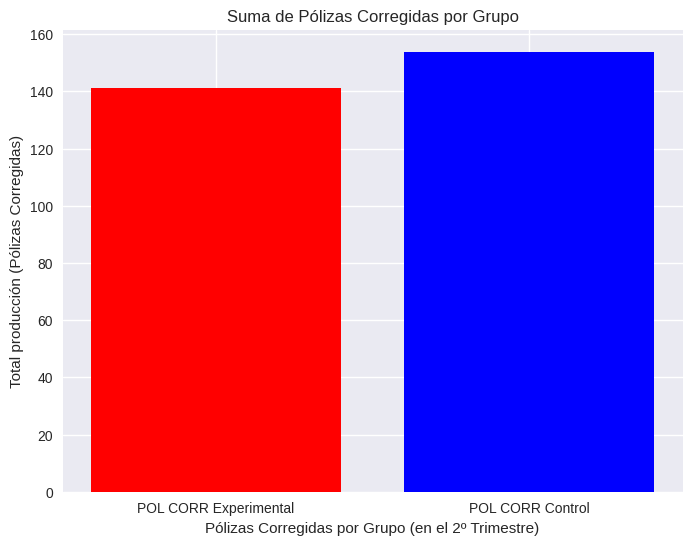

In [401]:
# Preparar datos para el gráfico
sumas_corr_comparativa = [suma_corr_trim2, suma_corr_trim2_ctrl]
columnas_corr_comparativa = ['POL CORR Experimental', 'POL CORR Control']

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_corr_comparativa, sumas_corr_comparativa, color=['red', 'blue'])
plt.xlabel('Pólizas Corregidas por Grupo (en el 2º Trimestre)')
plt.ylabel('Total producción (Pólizas Corregidas)')
plt.title('Suma de Pólizas Corregidas por Grupo')
plt.show()

In [402]:
print('En el segundo trimestre el grupo de control hizo', round(suma_corr_trim2_ctrl,2),'pólizas corregidas, mientras que el experimental', round(suma_corr_trim2,2),'.')
print('El grupo de control hizo un 100 % pólizas corregidas, mientras que el experimental', round((100*suma_corr_trim2)/suma_corr_trim2_ctrl,2),'%.')

En el segundo trimestre el grupo de control hizo 153.84 pólizas corregidas, mientras que el experimental 141.05 .
El grupo de control hizo un 100 % pólizas corregidas, mientras que el experimental 91.69 %.


####Pólizas Físicas y Corregidas - Media mensual
Se procede a realizar el estudio de manera mensual con las medias, teniendo en cuenta los agentes que hay en el mes (teniendo en cuenta los agentes que no estuvieran dados de alta enb el 1er trimestre y las bajas que se vayan produciendo).

In [432]:
bajas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27024 entries, 0 to 27023
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   RE               27024 non-null  object        
 1   REGIONAL         27024 non-null  object        
 2   SU               27024 non-null  object        
 3   SUCURSAL         27024 non-null  object        
 4   OF               27024 non-null  int64         
 5   OFICINA          27024 non-null  object        
 6   CODIGO           27024 non-null  int64         
 7   COD.CALL/SOLNET  27024 non-null  object        
 8   NIF              27024 non-null  object        
 9   NOMBRE           27024 non-null  object        
 10  TIPO AGENTE      27024 non-null  object        
 11  MAIL             18726 non-null  object        
 12  EMAIL PERSONAL   3865 non-null   object        
 13  F.ALTA           26991 non-null  datetime64[ns]
 14  F.BAJA           24632 non-null  datet

In [446]:
enero_bajas = bajas[bajas['F.BAJA'] <= pd.to_datetime('2024-01-01')]
febrero_bajas = bajas[bajas['F.BAJA'] <= pd.to_datetime('2024-02-01')]
marzo_bajas = bajas[bajas['F.BAJA'] <= pd.to_datetime('2024-03-01')]
abril_bajas = bajas[bajas['F.BAJA'] <= pd.to_datetime('2024-04-01')]
mayo_bajas = bajas[bajas['F.BAJA'] <= pd.to_datetime('2024-05-01')]
junio_bajas = bajas[bajas['F.BAJA'] <= pd.to_datetime('2024-06-01')]


enero_exp = Gr1[(Gr1['F.ALTA'] <= pd.to_datetime('2024-01-01')) & (~Gr1['LDAP'].isin(enero_bajas))]
febrero_exp = Gr1[(Gr1['F.ALTA'] <= pd.to_datetime('2024-02-01')) & (~Gr1['LDAP'].isin(febrero_bajas))]
marzo_exp = Gr1[(Gr1['F.ALTA'] <= pd.to_datetime('2024-03-01')) & (~Gr1['LDAP'].isin(marzo_bajas))]
abril_exp = Gr1[(Gr1['F.ALTA'] <= pd.to_datetime('2024-04-01')) & (~Gr1['LDAP'].isin(abril_bajas))]
mayo_exp = Gr1[(Gr1['F.ALTA'] <= pd.to_datetime('2024-05-01')) & (~Gr1['LDAP'].isin(mayo_bajas))]
junio_exp = Gr1[(Gr1['F.ALTA'] <= pd.to_datetime('2024-06-01')) & (~Gr1['LDAP'].isin(junio_bajas))]


enero_ctrl = Gr2[(Gr2['F.ALTA'] <= pd.to_datetime('2024-01-01')) & (~Gr2['LDAP'].isin(enero_bajas))]
febrero_ctrl = Gr2[(Gr2['F.ALTA'] <= pd.to_datetime('2024-02-01')) & (~Gr2['LDAP'].isin(febrero_bajas))]
marzo_ctrl = Gr2[(Gr2['F.ALTA'] <= pd.to_datetime('2024-03-01')) & (~Gr2['LDAP'].isin(marzo_bajas))]
abril_ctrl = Gr2[(Gr2['F.ALTA'] <= pd.to_datetime('2024-04-01')) & (~Gr2['LDAP'].isin(abril_bajas))]
mayo_ctrl = Gr2[(Gr2['F.ALTA'] <= pd.to_datetime('2024-05-01')) & (~Gr2['LDAP'].isin(mayo_bajas))]
junio_ctrl = Gr2[(Gr2['F.ALTA'] <= pd.to_datetime('2024-06-01')) & (~Gr2['LDAP'].isin(junio_bajas))]

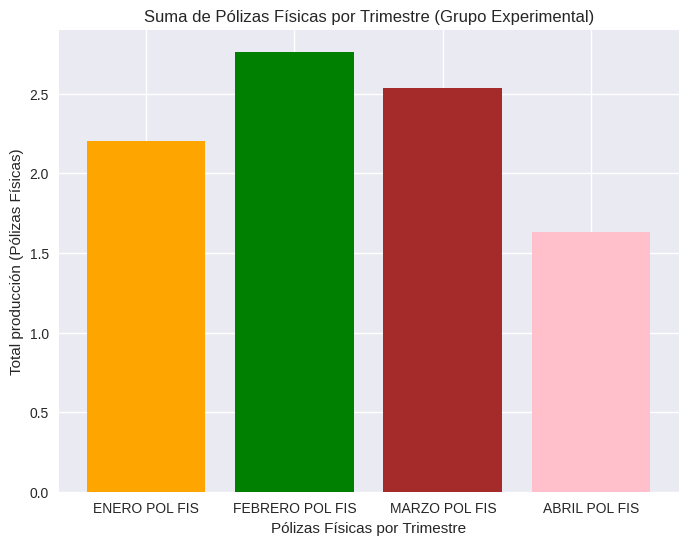

In [451]:
enero = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(enero_exp['LDAP'].unique())]
febrero = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(febrero_exp['LDAP'].unique())]
marzo = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(marzo_exp['LDAP'].unique())]
abril = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(abril_exp['LDAP'].unique())]
# mayo = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(mayo_exp['LDAP'].unique())]
# junio = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(junio_exp['LDAP'].unique())]

media_fis_enero_exp = enero['POL. FIS. 2024-01'].sum()/enero_exp.shape[0]
media_fis_febrero_exp = febrero['POL. FIS. 2024-02'].sum()/febrero_exp.shape[0]
media_fis_marzo_exp = marzo['POL. FIS. 2024-03'].sum()/marzo_exp.shape[0]
media_fis_abril_exp = abril['POL. FIS. 2024-04'].sum()/abril_exp.shape[0]
# media_fis_mayo_exp = mayo['POL. FIS. 2024-05'].sum()/mayo_exp.shape[0]
# media_fis_junio_exp = junio['POL. FIS. 2024-06'].sum()/junio_exp.shape[0]

# # Preparar datos para el gráfico
medias_fis_exp = [media_fis_enero_exp, media_fis_febrero_exp, media_fis_marzo_exp, media_fis_abril_exp]
columnas_fis = ['ENERO POL FIS', 'FEBRERO POL FIS', 'MARZO POL FIS', 'ABRIL POL FIS']

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_fis, medias_fis_exp, color=['orange', 'green', 'brown', 'pink'])
plt.xlabel('Pólizas Físicas por Trimestre')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Suma de Pólizas Físicas por Trimestre (Grupo Experimental)')
plt.show()

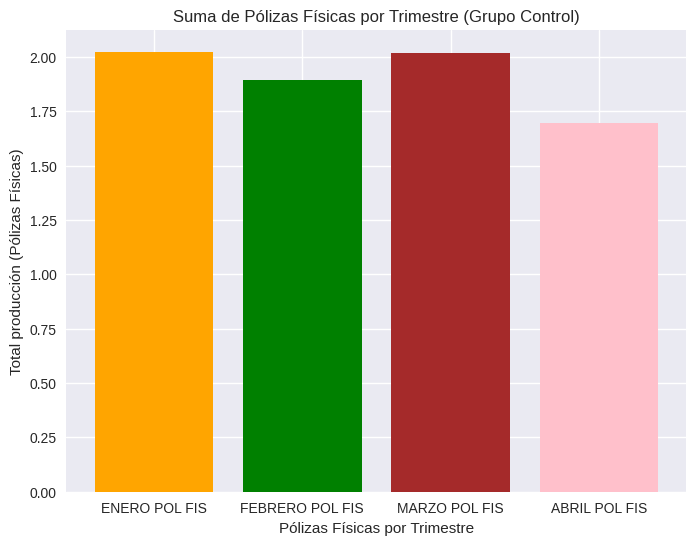

In [450]:
enero = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(enero_ctrl['LDAP'].unique())]
febrero = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(febrero_ctrl['LDAP'].unique())]
marzo = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(marzo_ctrl['LDAP'].unique())]
abril = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(abril_ctrl['LDAP'].unique())]
# mayo = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(mayo_ctrl['LDAP'].unique())]
# junio = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(junio_ctrl['LDAP'].unique())]

media_fis_enero_ctrl = enero['POL. FIS. 2024-01'].sum()/enero_ctrl.shape[0]
media_fis_febrero_ctrl = febrero['POL. FIS. 2024-02'].sum()/febrero_ctrl.shape[0]
media_fis_marzo_ctrl = marzo['POL. FIS. 2024-03'].sum()/marzo_ctrl.shape[0]
media_fis_abril_ctrl = abril['POL. FIS. 2024-04'].sum()/abril_ctrl.shape[0]
# media_fis_mayo_ctrl = mayo['POL. FIS. 2024-05'].sum()/mayo_ctrl.shape[0]
# media_fis_junio_ctrl = junio['POL. FIS. 2024-06'].sum()/junio_ctrl.shape[0]

# # Preparar datos para el gráfico
medias_fis_ctrl = [media_fis_enero_ctrl, media_fis_febrero_ctrl, media_fis_marzo_ctrl, media_fis_abril_ctrl]
# columnas_fis = ['ENERO POL FIS', 'FEBRERO POL FIS', 'MARZO POL FIS', 'ABRIL POL FIS']

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_fis, medias_fis_ctrl, color=['orange', 'green', 'brown', 'pink'])
plt.xlabel('Pólizas Físicas por Trimestre')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Suma de Pólizas Físicas por Trimestre (Grupo Control)')
plt.show()

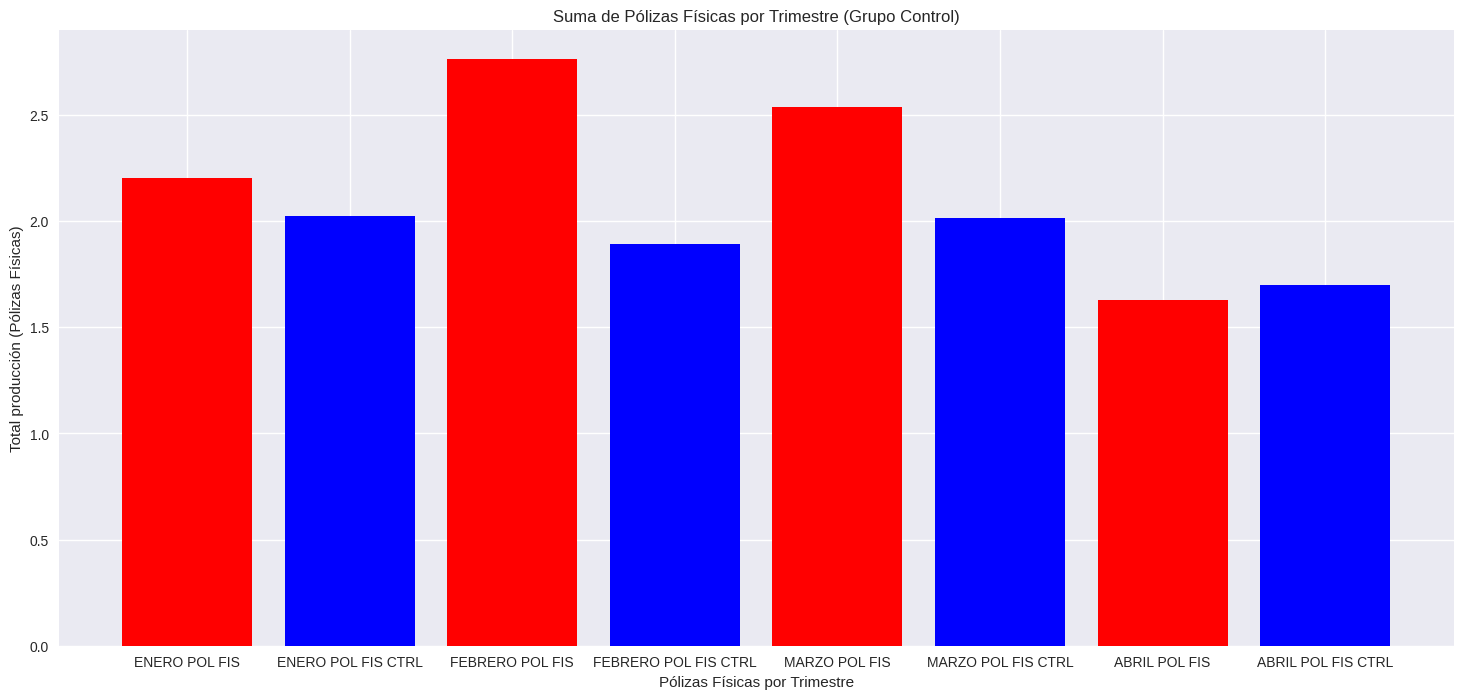

In [455]:
medias_fis = [media_fis_enero_exp, media_fis_enero_ctrl, media_fis_febrero_exp, media_fis_febrero_ctrl, media_fis_marzo_exp, media_fis_marzo_ctrl, media_fis_abril_exp, media_fis_abril_ctrl]
columnas_fis_total = ['ENERO POL FIS', 'ENERO POL FIS CTRL', 'FEBRERO POL FIS','FEBRERO POL FIS CTRL', 'MARZO POL FIS', 'MARZO POL FIS CTRL', 'ABRIL POL FIS', 'ABRIL POL FIS CTRL']

# Crear el gráfico de barras
plt.figure(figsize=(18, 8))
plt.bar(columnas_fis_total, medias_fis, color=['red', 'blue'])
plt.xlabel('Pólizas Físicas por Trimestre')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Suma de Pólizas Físicas por Trimestre (Grupo Control)')
plt.show()

**OTROS ESTUDIOS QUE SE PUEDEN HACER:**



*   Filtrar solo por tipo de evento READ para ver en una gráfica el impacto por sucursales (u oficinas o puntos de venta).
*   Usar como grupo de control_2 el grupo experimental en los 3 meses anteriores para ver cómo varía.